# Recyclable and Household Waste Classification with EfficientNetV2
1. Baseline Model : EfficientNetV2
  - Paper : [EfficientNetV2: Smaller Models and Faster Training](https://arxiv.org/pdf/2104.00298)
2. 성능 개선 시도
  - MBConv 블록에서 SE(Squeeze and Excitation) 대신 GLU(Gated Linear Units) 모듈 사용
  - Gated Linear Units (GLU)
    - Paper: [Language Modeling with Gated Convolutional Networks](https://arxiv.org/pdf/1612.08083)
    - gate mechanism을 도입하여, 입력을 두 개의 부분으로 나누고 하나는 원본 값을 그대로 전달하고, 다른 하나는 sigmoid를 통해 gate로 제어하여 선형 변환된 결과를 통과시킴
    - SE처럼 각 채널에 대해 중요도를 학습하기보다 각 채널에 대해 비선형성을 추가 -> 정보 흐름을 제어
    - 중요하지 않은 정보를 억제하고 중요한 정보를 강조하는 특성을 통해 모델 성능 향상 도모
3. 성능 개선 결과
  - Accuracy
    - `EfficientNetV2` (base) : 86.40%
    - `EfficientNetV2GLU` : 85.90%
  - **Inference Time** **(2.64 times faster at CPU, 2.27 times faster at GPU)**
    - `EfficientNetV2` : 5033ms(@CPU), 1586ms(@GPU)
    - `EfficientNetV2GLU` : 1904ms(@CPU), 699.686ms(@GPU)

## 1. Import Libraries, Configuration, Dataset Load

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

In [ ]:
# download dataset
!kaggle datasets download alistairking/recyclable-and-household-waste-classification

Dataset URL: https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification
License(s): MIT
100% 920M/920M [00:43<00:00, 24.0MB/s]
100% 920M/920M [00:43<00:00, 22.2MB/s]


In [ ]:
# configs 정의

CONFIGS = {
    # dataloader
    "num_workers": 2,
    "batch_size": 16,

    # train params
    "img_size": 256,
    "num_epochs": 30,
    "learning_rate": 0.001,
    "data_aug": True
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# 데이터셋 압축 풀기
import zipfile
import os

def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# 사용 예시
zip_path = '/content/recyclable-and-household-waste-classification.zip'  # 압축 파일 경로
extract_to = 'data'  # 파일을 해제할 폴더 경로

# 디렉토리가 없다면 생성
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

unzip_file(zip_path, extract_to)

In [ ]:
# random seed 고정 함수
def set_seed():
  random.seed(17)

In [ ]:
# 데이터 전처리 클래스
class WasteDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for subfolder in ['default', 'real_world']:
                subfolder_dir = os.path.join(class_dir, subfolder)
                image_names = os.listdir(subfolder_dir)
                random.shuffle(image_names)

                if split == 'train':
                    image_names = image_names[:int(0.6 * len(image_names))]
                elif split == 'val':
                    image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
                else: #split == 'test':
                    image_names = image_names[int(0.8 * len(image_names)):]

                for image_name in image_names:
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))
                    self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
set_seed()  # for reproduction

if CONFIGS["data_aug"]:
  train_transform = transforms.Compose([
      transforms.RandomResizedCrop(CONFIGS["img_size"], scale=(0.3, 1.0)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=torch.tensor(IMAGENET_DEFAULT_MEAN), std=torch.tensor(IMAGENET_DEFAULT_STD))
  ])
else:
  train_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=torch.tensor(IMAGENET_DEFAULT_MEAN), std=torch.tensor(IMAGENET_DEFAULT_STD))
  ])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=torch.tensor(IMAGENET_DEFAULT_MEAN), std=torch.tensor(IMAGENET_DEFAULT_STD))
])

dataset_path = "/content/data/images/images"
train_dataset = WasteDataset(dataset_path, split='train', transform=train_transform) # 데이터 증강
val_dataset = WasteDataset(dataset_path, split='val', transform=valid_transform)
test_dataset = WasteDataset(dataset_path, split='test', transform=valid_transform)
train_dataloader = DataLoader(train_dataset, batch_size=CONFIGS["batch_size"], num_workers=CONFIGS["num_workers"], pin_memory=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=CONFIGS["batch_size"], num_workers=CONFIGS["num_workers"], pin_memory=True, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=CONFIGS["batch_size"], num_workers=CONFIGS["num_workers"], pin_memory=True, shuffle=False)

print("* Number of classes :",len(train_dataset.classes), len(val_dataset.classes), len(test_dataset.classes))
print("* Dataset lengths :", len(train_dataset), len(val_dataset), len(test_dataset))
print()
print("* Image paths")
print([os.path.basename(x) for x in train_dataset.image_paths[:5]])
print([os.path.basename(x) for x in val_dataset.image_paths[:5]])
print([os.path.basename(x) for x in test_dataset.image_paths[:5]])
print()
print("* Train transform")
print(train_transform) # data augmentation
print("* Valid transform")
print(valid_transform)

* Number of classes : 30 30 30
* Dataset lengths : 9000 3000 3000

* Image paths
['Image_97.png', 'Image_206.png', 'Image_129.png', 'Image_179.png', 'Image_32.png']
['Image_28.png', 'Image_34.png', 'Image_171.png', 'Image_130.png', 'Image_154.png']
['Image_48.png', 'Image_114.png', 'Image_122.png', 'Image_221.png', 'Image_207.png']

* Train transform
Compose(
    RandomResizedCrop(size=(256, 256), scale=(0.3, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)
* Valid transform
Compose(
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)


## 2. Model Implementation (EfficientNetV2)

In [ ]:
Eff_V2_SETTINGS = {
    # expansion factor, kernel_size, stride, n_in, n_out, num_layers, use_fusedMBCONV
    's' : [
        [1, 3, 1, 24, 24, 2, True],
        [4, 3, 2, 24, 48, 4, True],
        [4, 3, 2, 48, 64, 4, True],
        [4, 3, 2, 64, 128, 6, False],
        [6, 3, 1, 128, 160, 9, False],
        [6, 3, 2, 160, 256, 15, False]
    ],

    'm' : [
        [1, 3, 1, 24, 24, 3, True],
        [4, 3, 2, 24, 48, 5, True],
        [4, 3, 2, 48, 80, 5, True],
        [4, 3, 2, 80, 160, 7, False],
        [6, 3, 1, 160, 176, 14, False],
        [6, 3, 2, 176, 304, 18, False],
        [6, 3, 1, 304, 512, 5, False]
    ],

    'l' : [
        [1, 3, 1, 32, 32, 4, True],
        [4, 3, 2, 32, 64, 7, True],
        [4, 3, 2, 64, 96, 7, True],
        [4, 3, 2, 96, 192, 10, False],
        [6, 3, 1, 192, 224, 19, False],
        [6, 3, 2, 224, 384, 25, False],
        [6, 3, 1, 384, 640, 7, False]
    ]
}

### 2-1. Convolution + Batch Normalization + Activation Class, Stochastic Depth Class

In [ ]:
# simple Convolution + Batch Normalization + Activation Class
class ConvBnAct(nn.Module):

    def __init__(
        self,
        n_in, # in_channels
        n_out, # out_channels
        k_size = 3, # Kernel Size
        stride = 1,
        padding = 0,
        groups = 1,
        act = True,
        bn = True,
        bias = False
    ):
        super(ConvBnAct, self).__init__()

        self.conv = nn.Conv2d(n_in, n_out, kernel_size = k_size, stride = stride,
                              padding = padding, groups = groups, bias = bias
                             )
        self.batch_norm = nn.BatchNorm2d(n_out) if bn else nn.Identity()
        self.activation = nn.SiLU() if act else nn.Identity() # pointwise conv에서는 활성화 함수 act = False

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)

        return x

# Stochastic Depth Class for kernel dropout in FusedMBconv block
class StochasticDepth(nn.Module):

    def __init__(
        self,
        survival_prob = 0.8
    ):
        super(StochasticDepth, self).__init__()

        self.p =  survival_prob

    def forward(self, x):

        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.p

        return torch.div(x, self.p) * binary_tensor

### 2-2. SE and GLU module

In [ ]:
# SE module for the base EfficientNetV2
class SqueezeExcitation(nn.Module):

    def __init__(
        self,
        n_in, # In_channels
        reduced_dim
    ):
        super(SqueezeExcitation, self).__init__()

        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excite = nn.Sequential(nn.Conv2d(n_in, reduced_dim, kernel_size=1),
                                   nn.SiLU(),
                                   nn.Conv2d(reduced_dim, n_in, kernel_size=1),
                                   nn.Sigmoid()
                                   )

    def forward(self, x):
        y = self.squeeze(x)
        y = self.excite(y)

        return x * y

# GLU module for EfficientNetV2GLU
class GLU(nn.Module):

    def __init__(self):
        super(GLU, self).__init__()

    def forward(self, x):
        # x는 [batch_size, channels, height, width] 형태
        # x를 두 개의 부분으로 나눠서 GLU 적용
        n, c, h, w = x.shape
        x1, x2 = x.chunk(2, dim=1)  # 채널 차원에서 두 개로 나누기
        return x1 * torch.sigmoid(x2)

### 2-3. MBConv Class with SE and GLU

In [ ]:
# MBCONV Class for the base EfficientNetV2 (with SE)
class MBConvN(nn.Module):

    def __init__(
        self,
        n_in, # in_channels
        n_out, # out_channels
        k_size = 3, # kernel_size
        stride = 1,
        expansion_factor = 4,
        reduction_factor = 4, # for SqueezeExcitation Block
        survival_prob = 0.8 # for StochasticDepth Block
    ):
        super(MBConvN, self).__init__()
        reduced_dim = int(n_in//4)
        expanded_dim = int(expansion_factor * n_in)
        padding = (k_size - 1)//2

        self.use_residual = (n_in == n_out) and (stride == 1)
        self.expand = nn.Identity() if (expansion_factor == 1) else ConvBnAct(n_in, expanded_dim, k_size = 1) # 1x1 conv
        self.depthwise_conv = ConvBnAct(expanded_dim, expanded_dim,
                                        k_size, stride = stride,
                                        padding = padding, groups = expanded_dim
                                       ) # 3x3 depthwise conv
        self.se = SqueezeExcitation(expanded_dim, reduced_dim)
        self.drop_layers = StochasticDepth(survival_prob)
        # pointwise conv (활성화 함수 X)
        self.pointwise_conv = ConvBnAct(expanded_dim, n_out, k_size = 1, act = False)

    def forward(self, x):

        residual = x.clone()
        x = self.expand(x)
        x = self.depthwise_conv(x)
        x = self.se(x)
        x = self.pointwise_conv(x)

        if self.use_residual:
            x = self.drop_layers(x)
            x += residual

        return x

In [ ]:
# MBConvGLU Class for EfficientNetV2GLU (with GLU)
class MBConvNGLU(nn.Module):
    def __init__(
        self,
        n_in,  # in_channels
        n_out, # out_channels
        k_size = 3, # kernel_size
        stride = 1,
        expansion_factor = 4,
        survival_prob = 0.8 # for StochasticDepth Block
    ):
        super(MBConvNGLU, self).__init__()
        expanded_dim = int(expansion_factor * n_in)  # expansion_factor 적용
        padding = (k_size - 1) // 2

        self.use_residual = (n_in == n_out) and (stride == 1)
        self.expand = nn.Identity() if (expansion_factor == 1) else ConvBnAct(n_in, expanded_dim, k_size=1)  # 1x1 conv
        self.depthwise_conv = ConvBnAct(expanded_dim, expanded_dim,
                                        k_size, stride=stride,
                                        padding=padding, groups=expanded_dim)  # 3x3 depthwise conv

        self.glu = GLU()  # SE 대신 GLU를 사용

        self.drop_layers = StochasticDepth(survival_prob)
        # pointwise conv (활성화 함수 X)
        self.pointwise_conv = ConvBnAct(expanded_dim // 2, n_out, k_size=1, act=False)  # expanded_dim -> expanded_dim // 2

    def forward(self, x):
        residual = x.clone()
        x = self.expand(x)
        x = self.depthwise_conv(x)

        # SE 대신 GLU 적용
        x = self.glu(x)

        x = self.pointwise_conv(x)

        if self.use_residual:
            x = self.drop_layers(x)
            x += residual

        return x

In [ ]:
# Fused-MBCONV Class
class FusedMBConvN(nn.Module):

    def __init__(
        self,
        n_in, # in_channels
        n_out, # out_channels
        k_size = 3, # kernel_size
        stride = 1,
        expansion_factor = 4,
        reduction_factor = 4, # for SqueezeExcitation Block
        survival_prob = 0.8 # for StochasticDepth Block
    ):
        super(FusedMBConvN, self).__init__()

        reduced_dim = int(n_in//4)
        expanded_dim = int(expansion_factor * n_in)
        padding = (k_size - 1)//2

        self.use_residual = (n_in == n_out) and (stride == 1)
        # MBConv의 (1x1 conv + 3x3 depthwise conv) 대신에 하나의 3x3 conv 사용
        #self.expand = nn.Identity() if (expansion_factor == 1) else ConvBnAct(n_in, expanded_dim, k_size = 1)
        self.conv = ConvBnAct(n_in, expanded_dim,
                              k_size, stride = stride,
                              padding = padding, groups = 1
                             ) # 3x3 conv
        # self.se = SqueezeExcitation(expanded_dim, reduced_dim)
        self.drop_layers = StochasticDepth(survival_prob)
        # for Fused-MBConv1 / Fused-MBConv4
        self.pointwise_conv = nn.Identity() if (expansion_factor == 1) else ConvBnAct(expanded_dim, n_out, k_size = 1, act = False) # pointwise conv (활성화 함수 X)


    def forward(self, x):

        residual = x.clone()
        # x = self.conv(x)
        x = self.conv(x)
        # x = self.se(x) # s version에서는 fused MBConv에서 SE 사용하지 않음
        x = self.pointwise_conv(x)

        if self.use_residual:
            x = self.drop_layers(x)
            x += residual

        return x

### 2-4. EfficientNetV2-S (base)

In [ ]:
class EfficientNetV2(nn.Module):

    def __init__(
    self,
    version = 's',
    dropout_rate = 0.2,
    num_classes = 30
    ):
        super(EfficientNetV2, self).__init__()
        last_channel = 1280
        self.features = self._feature_extractor(version, last_channel)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(dropout_rate, inplace = True),
            nn.Linear(last_channel, num_classes)
        )

    def forward(self, x):
      x = self.features(x)
      x = self.classifier(x)
      return x

    def _feature_extractor(self, version, last_channel):

        # Extract the Config
        config = Eff_V2_SETTINGS[version]

        layers = []
        layers.append(ConvBnAct(3, config[0][3], k_size = 3, stride = 2, padding = 1)) # stage 0: 3x3 Conv append
        #in_channel = config[0][3]

        for (expansion_factor, k, stride, n_in, n_out, num_layers, use_fused) in config: # 버전 별 config에 있는대로 모델 구축

            if use_fused:
                layers += [FusedMBConvN(n_in if repeat==0 else n_out,
                                        n_out,
                                        k_size=k,
                                        stride = stride if repeat==0 else 1,
                                        expansion_factor=expansion_factor
                                       ) for repeat in range(num_layers)
                          ]
            else:

                layers += [MBConvN(n_in if repeat==0 else n_out, # basic MBConvN 사용
                                   n_out,
                                   k_size=k,
                                   stride = stride if repeat==0 else 1,
                                   expansion_factor=expansion_factor
                                   ) for repeat in range(num_layers)
                      ]

        layers.append(ConvBnAct(config[-1][4], last_channel, k_size = 1))

        return nn.Sequential(*layers)

### 2-5. EfficientNetV2-S with GLU

In [ ]:
class EfficientNetV2GLU(nn.Module):

    def __init__(
    self,
    version = 's',
    dropout_rate = 0.2,
    num_classes = 30
    ):
        super(EfficientNetV2GLU, self).__init__()
        last_channel = 1280
        self.features = self._feature_extractor(version, last_channel)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(dropout_rate, inplace = True),
            nn.Linear(last_channel, num_classes)
        )

    def forward(self, x):
      x = self.features(x)
      x = self.classifier(x)
      return x

    def _feature_extractor(self, version, last_channel):

        # Extract the Config
        config = Eff_V2_SETTINGS[version]

        layers = []
        layers.append(ConvBnAct(3, config[0][3], k_size = 3, stride = 2, padding = 1)) # stage 0: 3x3 Conv append
        #in_channel = config[0][3]

        for (expansion_factor, k, stride, n_in, n_out, num_layers, use_fused) in config: # 버전 별 config에 있는대로 모델 구축

            if use_fused:
                layers += [FusedMBConvN(n_in if repeat==0 else n_out,
                                        n_out,
                                        k_size=k,
                                        stride = stride if repeat==0 else 1,
                                        expansion_factor=expansion_factor
                                       ) for repeat in range(num_layers)
                          ]
            else:

                layers += [MBConvNGLU(n_in if repeat==0 else n_out, # MBConvNGLU 사용
                                   n_out,
                                   k_size=k,
                                   stride = stride if repeat==0 else 1,
                                   expansion_factor=expansion_factor
                                   ) for repeat in range(num_layers)
                      ]

        layers.append(ConvBnAct(config[-1][4], last_channel, k_size = 1))

        return nn.Sequential(*layers)

## 3. Model Instance Definition and Training Loop
- Optimizer : Adam
  - Learning Rate = 0.001
- Dropout : 0.2

### 3-1. EfficientNetv2 (base)

In [ ]:
from torchvision import models
import torch.optim as optim

# Efficientnet model 인스턴스 생성
version = 's'
model1 = EfficientNetV2(version = version, dropout_rate = 0.2, num_classes = 30)
model1 = model1.to(device) # Load model to device

# 손실함수, 옵티마이저
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model1.parameters(), lr=CONFIGS["learning_rate"])

In [ ]:
start_epoch = 68
end_epoch = 100
checkpoint_path = '/content/efficientv2base-best-epoch68.pt'

if os.path.exists(os.path.dirname(checkpoint_path)):
    checkpoint = torch.load(checkpoint_path)
    model1.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    print(f"Successfully loaded ckpt from {checkpoint_path}")
else:
    start_epoch = 0
    end_epoch = 0
    train_losses = []
    val_losses = []
    print("Start a new training")

<ipython-input-18-b08dc0374b30>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Successfully loaded ckpt from /content/efficientv2base-best-epoch68.pt


In [ ]:
import math

best_valid_loss = float('inf')
train_accuracies = []
val_accuracies = []

if end_epoch == 0:
    print(f"Start training...")
else:
    print(f"Resume training from epoch = {start_epoch}...")

end_epoch = end_epoch if end_epoch else CONFIGS['num_epochs']

for i, epoch in enumerate(range(start_epoch, end_epoch)):
    # Training
    model1.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model1(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

         # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model1.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            outputs = model1(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_dataset)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_loss < best_valid_loss:
      torch.save({'model_state_dict': model1.state_dict(),
                 'optimizer_state_dict': optimizer.state_dict(),
                 'train_losses': train_losses,
                 'val_losses': val_losses}, f'efficientv2base-best-epoch{epoch+1}.pt') # best_valid_loss를 갖는 체크포인트 저장
      print("Saved current state!")
      best_valid_loss = val_loss

    print(f"Epoch [{epoch+1}/{end_epoch}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

print("Training completed!")

Resume training from epoch = 68...
Saved current state!
Epoch [69/100], Train Loss: 0.5241, Train Accuracy: 82.88%, Val Loss: 0.6853, Val Accuracy: 82.47%
Saved current state!
Epoch [70/100], Train Loss: 0.5226, Train Accuracy: 83.03%, Val Loss: 0.6390, Val Accuracy: 83.57%
Epoch [71/100], Train Loss: 0.5176, Train Accuracy: 82.49%, Val Loss: 0.6680, Val Accuracy: 83.23%
Saved current state!
Epoch [72/100], Train Loss: 0.4993, Train Accuracy: 84.00%, Val Loss: 0.6227, Val Accuracy: 83.43%
Epoch [73/100], Train Loss: 0.4886, Train Accuracy: 83.62%, Val Loss: 0.6577, Val Accuracy: 83.10%
Epoch [74/100], Train Loss: 0.4879, Train Accuracy: 84.02%, Val Loss: 0.6468, Val Accuracy: 83.40%
Epoch [75/100], Train Loss: 0.4564, Train Accuracy: 85.09%, Val Loss: 0.6418, Val Accuracy: 84.20%
Epoch [76/100], Train Loss: 0.4584, Train Accuracy: 84.79%, Val Loss: 0.6493, Val Accuracy: 84.30%
Epoch [77/100], Train Loss: 0.4661, Train Accuracy: 85.00%, Val Loss: 0.7024, Val Accuracy: 82.27%
Epoch [78/1

#### 3-1-1. Training and Validation Loss Visualization

<ipython-input-22-5e2d276db05b>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


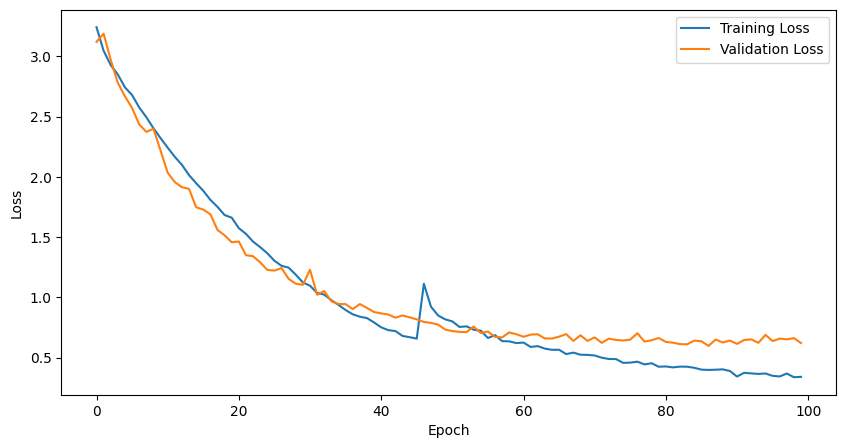

In [ ]:
torch.save({'model_state_dict': model1.state_dict(),
                 'optimizer_state_dict': optimizer.state_dict(),
                 'train_losses': train_losses,
                 'val_losses': val_losses}, f'efficientv2base-best-epoch{100}.pt')

checkpoint_path = '/content/efficientv2base-best-epoch100.pt'

if os.path.exists(os.path.dirname(checkpoint_path)):
    checkpoint = torch.load(checkpoint_path)
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 3-1-2. Test Accuracy

In [ ]:
# best 파라미터 통한 테스트셋 평가

PATH = '/content/efficientv2base-best-epoch87.pt'
checkpoint = torch.load(PATH)
model1.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded ckpt from '{PATH}'")
model1.to(device)

from sklearn.metrics import accuracy_score

model1.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model1(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

<ipython-input-23-b79d364a3d21>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PATH)


Loaded ckpt from '/content/efficientv2base-best-epoch87.pt'
Test Accuracy: 86.43%


### 3-2. EfficientNetV2GLU

In [ ]:
from torchvision import models
import torch.optim as optim

# Efficientnet model 인스턴스 생성
version = 's'
model2 = EfficientNetV2GLU(version = version, dropout_rate = 0.2, num_classes = 30)
model2 = model2.to(device) # Load model to device

# 손실함수, 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=CONFIGS["learning_rate"])

In [ ]:
start_epoch = 100
end_epoch = 110
checkpoint_path = '/content/efficientv2-best-epoch100.pt'

if os.path.exists(os.path.dirname(checkpoint_path)):
    checkpoint = torch.load(checkpoint_path)
    model2.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    print(f"Successfully loaded ckpt from {checkpoint_path}")
else:
    start_epoch = 0
    end_epoch = 0
    train_losses = []
    val_losses = []
    print("Start a new training")

<ipython-input-43-1d3668591678>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Successfully loaded ckpt from /content/efficientv2-best-epoch100.pt


In [ ]:
import math

best_valid_loss = float('inf')
train_accuracies = []
val_accuracies = []

if end_epoch == 0:
    print(f"Start training...")
else:
    print(f"Resume training from epoch = {start_epoch}...")

end_epoch = end_epoch if end_epoch else CONFIGS['num_epochs']

for i, epoch in enumerate(range(start_epoch, end_epoch)):
    # Training
    model2.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model2(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

         # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model2.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            outputs = model2(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_dataset)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_loss < best_valid_loss:
      torch.save({'model_state_dict': model2.state_dict(),
                 'optimizer_state_dict': optimizer.state_dict(),
                 'train_losses': train_losses,
                 'val_losses': val_losses}, f'efficientv2-best-epoch{epoch+1}.pt') # best_valid_loss를 갖는 체크포인트 저장
      print("Saved current state!")
      best_valid_loss = val_loss

    print(f"Epoch [{epoch+1}/{end_epoch}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

print("Training completed!")

Resume training from epoch = 100...
Saved current state!
Epoch [101/110], Train Loss: 0.3246, Train Accuracy: 88.98%, Val Loss: 0.5904, Val Accuracy: 85.37%
Epoch [102/110], Train Loss: 0.3430, Train Accuracy: 88.29%, Val Loss: 0.6250, Val Accuracy: 83.83%
Epoch [103/110], Train Loss: 0.3500, Train Accuracy: 87.78%, Val Loss: 0.6056, Val Accuracy: 84.77%
Epoch [104/110], Train Loss: 0.3339, Train Accuracy: 88.74%, Val Loss: 0.6235, Val Accuracy: 84.27%
Epoch [105/110], Train Loss: 0.3283, Train Accuracy: 89.03%, Val Loss: 0.6428, Val Accuracy: 83.73%
Epoch [106/110], Train Loss: 0.3358, Train Accuracy: 88.72%, Val Loss: 0.5934, Val Accuracy: 84.67%
Epoch [107/110], Train Loss: 0.3093, Train Accuracy: 89.33%, Val Loss: 0.6085, Val Accuracy: 84.60%
Epoch [108/110], Train Loss: 0.3169, Train Accuracy: 89.52%, Val Loss: 0.6239, Val Accuracy: 83.90%
Epoch [109/110], Train Loss: 0.3313, Train Accuracy: 89.10%, Val Loss: 0.6041, Val Accuracy: 85.13%
Epoch [110/110], Train Loss: 0.3082, Train 

#### 3-2-1. Training and Validation Loss Visualization

<ipython-input-46-31a3c9f735bd>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


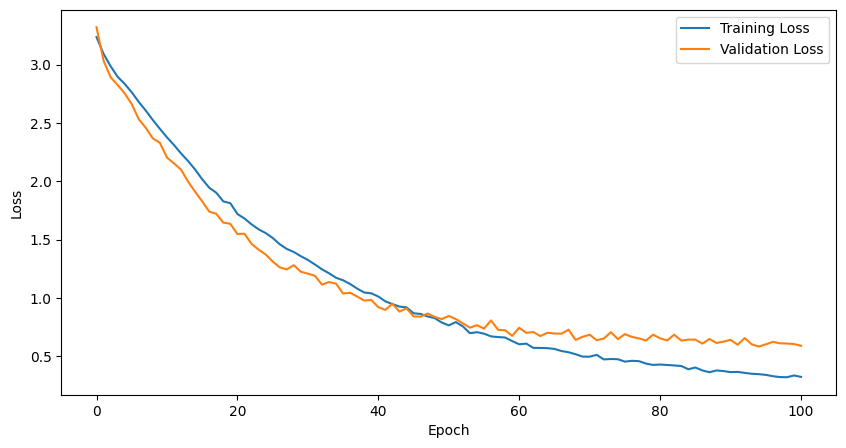

In [ ]:
checkpoint_path = '/content/efficientv2-best-epoch101.pt'

if os.path.exists(os.path.dirname(checkpoint_path)):
    checkpoint = torch.load(checkpoint_path)
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 3-2-2. Test Accuracy
- Attained 85.90% on testset

In [ ]:
# best 파라미터 통한 테스트셋 평가

PATH = '/content/efficientv2-best-epoch101.pt'
checkpoint = torch.load(PATH)
model2.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded ckpt from '{PATH}'")
model2.to(device)

from sklearn.metrics import accuracy_score

model2.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model2(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

<ipython-input-48-9770f340e8f4>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PATH)


Loaded ckpt from '/content/efficientv2-best-epoch101.pt'
Test Accuracy: 85.90%


#### 3-2-3. Visualization of Model Predictions

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (12, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

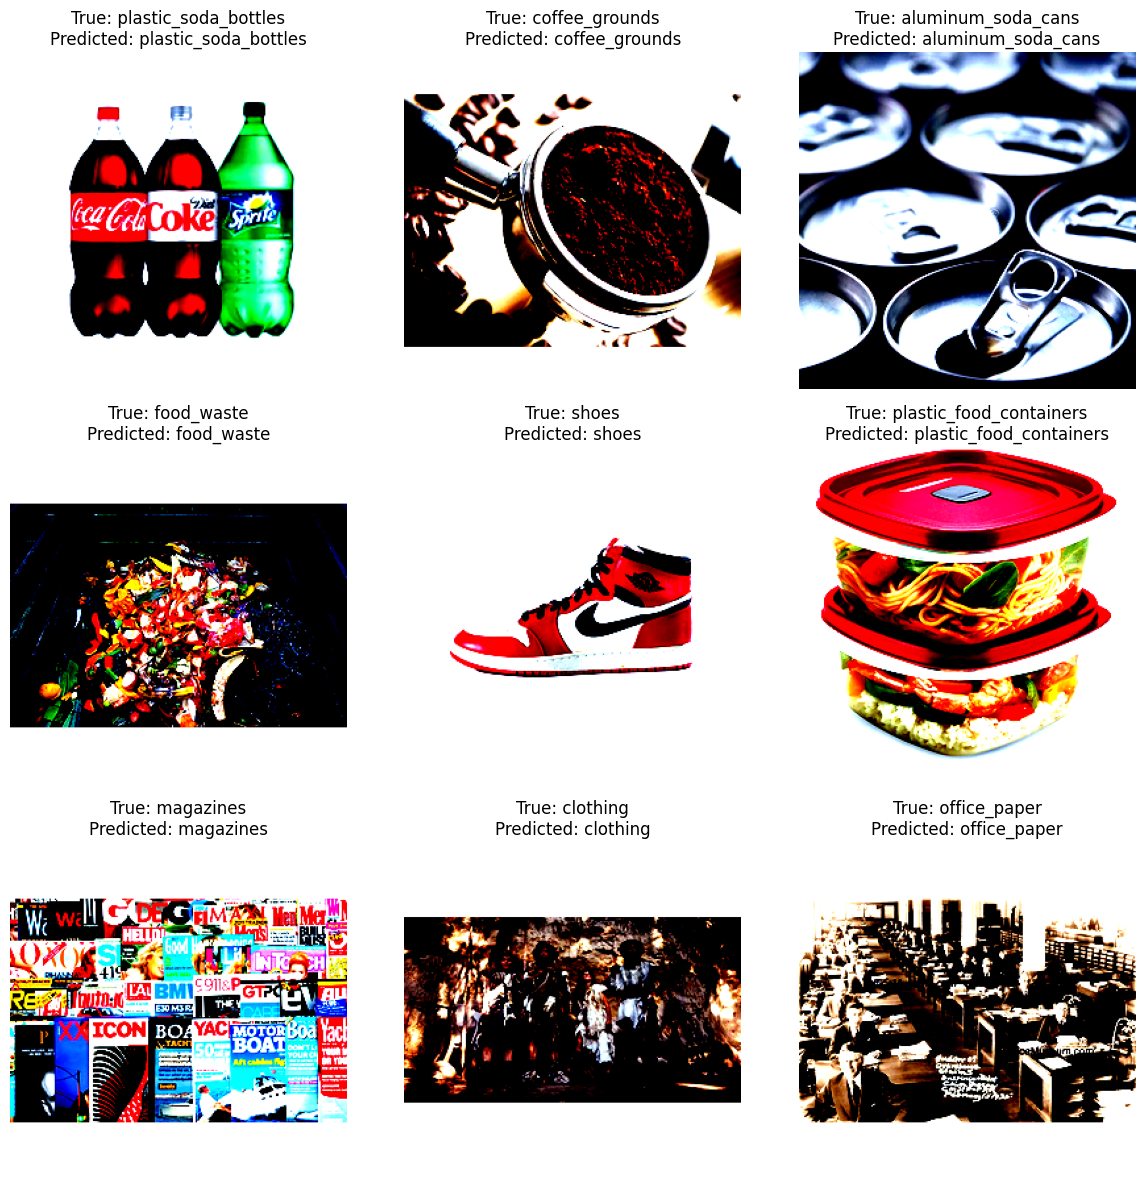

In [ ]:
# Perform sample inferences on random test images with different labels
model2.eval()
with torch.no_grad():
    indices = list(range(len(test_dataset)))
    random.shuffle(indices)

    selected_images = []
    selected_labels = []
    selected_predicted = []

    for index in indices:
        image, label = test_dataset[index]
        image = image.unsqueeze(0).to('cuda')

        output = model2(image)
        _, predicted = torch.max(output, 1)

        if label not in selected_labels:
            selected_images.append(image)
            selected_labels.append(label)
            selected_predicted.append(predicted.item())

        if len(selected_labels) == 9:
            break

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(9):
        axes[i].imshow(selected_images[i].squeeze().cpu().permute(1, 2, 0))
        axes[i].set_title(f"True: {train_dataset.classes[selected_labels[i]]}\nPredicted: {train_dataset.classes[selected_predicted[i]]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

## 4. Inference Time Comparison

Model Type       | @ CPU [ms]   | @ GPU [ms]   |
-----------------|--------------|--------------|
`EfficientNetV2` |     5033     |     1586    |
`EfficientNetV2GLU`  |   **1904**      |    **699.686**     |

In [ ]:
image_path = 'data/images/images/aerosol_cans/real_world/Image_1.png'

input_data = Image.open(image_path)
input_data = valid_transform(input_data).unsqueeze(0).to('cuda')
input_data.shape

NUM_ITERS = 100

In [ ]:
# EfficientNetV2 (base)

import torch.profiler

model1 = EfficientNetV2(version = 's', dropout_rate = 0.2, num_classes = 30)
PATH = '/content/efficientv2base-best-epoch87.pt'
checkpoint = torch.load(PATH)
model1.load_state_dict(checkpoint['model_state_dict'])

test_model1 = model1.to(device)

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    record_shapes=False,
    profile_memory=False
) as prof:
    with torch.no_grad():
      for _ in range(NUM_ITERS):
        output = test_model1(input_data)

print(prof.key_averages().table(sort_by="self_cpu_time_total"))

<ipython-input-17-6741e593a13e>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PATH)


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       cudaLaunchKernel        23.86%        1.201s        23.86%        1.201s      13.994us       3.104us         0.00%       3.104us       0.000us         85800  
                                aten::cudnn_convolution        22.44%        1.129s        31.32%        1.576s     112.593us     531.722ms        33.53%     531.725ms      37.980us         14000  
         

In [ ]:
# EfficientNetV2GLU

import torch.profiler

model2 = EfficientNetV2GLU(version = 's', dropout_rate = 0.2, num_classes = 30)
PATH = '/content/efficientv2-best-epoch101.pt'
checkpoint = torch.load(PATH)
model2.load_state_dict(checkpoint['model_state_dict'])


test_model2 = model2.to(device)

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    record_shapes=False,
    profile_memory=False
) as prof:
    with torch.no_grad():
      for _ in range(NUM_ITERS):
        output = test_model2(input_data)

print(prof.key_averages().table(sort_by="self_cpu_time_total"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       cudaLaunchKernel        16.78%     319.534ms        16.78%     319.534ms       7.681us       0.000us         0.00%       0.000us       0.000us         41600  
                                aten::cudnn_convolution        15.44%     293.935ms        21.91%     417.289ms      52.161us     414.165ms        59.19%     414.165ms      51.771us          8000  
         

## 5. Ablation
### 5-1. Data Augmentation
- Ablation Study on the Data Augmentation of the baseline (`EfficientNetV2`)

In [ ]:
# configs 정의

CONFIGS = {
    # dataloader
    "num_workers": 2,
    "batch_size": 16,

    # train params
    "img_size": 256,
    "num_epochs": 50,
    "learning_rate": 0.001,
    "data_aug": False
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
set_seed()  # for reproduction

if CONFIGS["data_aug"]:
  train_transform = transforms.Compose([
      transforms.RandomResizedCrop(CONFIGS["img_size"], scale=(0.3, 1.0)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=torch.tensor(IMAGENET_DEFAULT_MEAN), std=torch.tensor(IMAGENET_DEFAULT_STD))
  ])
else:
  train_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=torch.tensor(IMAGENET_DEFAULT_MEAN), std=torch.tensor(IMAGENET_DEFAULT_STD))
  ])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=torch.tensor(IMAGENET_DEFAULT_MEAN), std=torch.tensor(IMAGENET_DEFAULT_STD))
])

dataset_path = "/content/data/images/images"
train_dataset = WasteDataset(dataset_path, split='train', transform=train_transform) # 데이터 증강
val_dataset = WasteDataset(dataset_path, split='val', transform=valid_transform)
test_dataset = WasteDataset(dataset_path, split='test', transform=valid_transform)
train_dataloader = DataLoader(train_dataset, batch_size=CONFIGS["batch_size"], num_workers=CONFIGS["num_workers"], pin_memory=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=CONFIGS["batch_size"], num_workers=CONFIGS["num_workers"], pin_memory=True, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=CONFIGS["batch_size"], num_workers=CONFIGS["num_workers"], pin_memory=True, shuffle=False)

print("* Number of classes :",len(train_dataset.classes), len(val_dataset.classes), len(test_dataset.classes))
print("* Dataset lengths :", len(train_dataset), len(val_dataset), len(test_dataset))
print()
print("* Image paths")
print([os.path.basename(x) for x in train_dataset.image_paths[:5]])
print([os.path.basename(x) for x in val_dataset.image_paths[:5]])
print([os.path.basename(x) for x in test_dataset.image_paths[:5]])
print()
print("* Train transform")
print(train_transform) # data augmentation
print("* Valid transform")
print(valid_transform)

* Number of classes : 30 30 30
* Dataset lengths : 9000 3000 3000

* Image paths
['Image_97.png', 'Image_206.png', 'Image_129.png', 'Image_179.png', 'Image_32.png']
['Image_28.png', 'Image_34.png', 'Image_171.png', 'Image_130.png', 'Image_154.png']
['Image_48.png', 'Image_114.png', 'Image_122.png', 'Image_221.png', 'Image_207.png']

* Train transform
Compose(
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)
* Valid transform
Compose(
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)


In [ ]:
from torchvision import models
import torch.optim as optim

# Efficientnet model 인스턴스 생성
version = 's'
model = EfficientNetV2(version = version, dropout_rate = 0.2, num_classes = 30)
model = model.to(device) # Load model to device

# 손실함수, 옵티마이저
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=CONFIGS["learning_rate"])

In [ ]:
start_epoch = 0
end_epoch = 0
checkpoint_path = ''

if os.path.exists(os.path.dirname(checkpoint_path)):
    checkpoint = torch.load(checkpoint_path)
    model2.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    print(f"Successfully loaded ckpt from {checkpoint_path}")
else:
    start_epoch = 0
    end_epoch = 0
    train_losses = []
    val_losses = []
    print("Start a new training")

Start a new training


In [ ]:
import math

best_valid_loss = float('inf')
train_accuracies = []
val_accuracies = []

if end_epoch == 0:
    print(f"Start training...")
else:
    print(f"Resume training from epoch = {start_epoch}...")

end_epoch = end_epoch if end_epoch else CONFIGS['num_epochs']

for i, epoch in enumerate(range(start_epoch, end_epoch)):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

         # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_dataset)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_loss < best_valid_loss:
      torch.save({'model_state_dict': model.state_dict(),
                 'optimizer_state_dict': optimizer.state_dict(),
                 'train_losses': train_losses,
                 'val_losses': val_losses}, f'efficientv2base-best-epoch{epoch+1}.pt') # best_valid_loss를 갖는 체크포인트 저장
      print("Saved current state!")
      best_valid_loss = val_loss

    print(f"Epoch [{epoch+1}/{end_epoch}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

print("Training completed!")

Start training...
Saved current state!
Epoch [1/50], Train Loss: 3.3788, Train Accuracy: 5.31%, Val Loss: 3.2777, Val Accuracy: 7.33%
Saved current state!
Epoch [2/50], Train Loss: 3.2158, Train Accuracy: 8.91%, Val Loss: 3.2499, Val Accuracy: 9.13%
Saved current state!
Epoch [3/50], Train Loss: 3.0873, Train Accuracy: 12.47%, Val Loss: 2.9828, Val Accuracy: 15.73%
Saved current state!
Epoch [4/50], Train Loss: 2.9827, Train Accuracy: 15.09%, Val Loss: 2.8475, Val Accuracy: 18.07%
Saved current state!
Epoch [5/50], Train Loss: 2.8751, Train Accuracy: 17.73%, Val Loss: 2.7067, Val Accuracy: 19.93%
Saved current state!
Epoch [6/50], Train Loss: 2.7480, Train Accuracy: 20.94%, Val Loss: 2.4878, Val Accuracy: 27.43%
Saved current state!
Epoch [7/50], Train Loss: 2.5813, Train Accuracy: 25.94%, Val Loss: 2.3600, Val Accuracy: 31.27%
Saved current state!
Epoch [8/50], Train Loss: 2.4436, Train Accuracy: 29.44%, Val Loss: 2.2447, Val Accuracy: 34.17%
Saved current state!
Epoch [9/50], Train L

In [ ]:
# best 파라미터 통한 테스트셋 평가

PATH = '/content/efficientv2base-best-epoch21.pt'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded ckpt from '{PATH}'")
model.to(device)

from sklearn.metrics import accuracy_score

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

<ipython-input-27-0a39c5ade706>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PATH)


Loaded ckpt from '/content/efficientv2base-best-epoch21.pt'
Test Accuracy: 80.13%
